# Energy-Based Models - Home Assignment

Energy-Based Models (EBMs). There are two parts for this project:
1. We will implement a very simple EBM and train it on a 2D toy dataset using the Maximum Likelihood Estimation (MLE) method with Markov Chain Monte Carlo (MCMC) sampling.
2. We will change the training method to Noise Contrastive Estimation (NCE) and its variant conditional NCE (cNCE) and train a model on 2D toy datasets. 

### Conda environment
You can use the same environment as in the Normalizing Flows assignment. Otherwise, you can create a new environment with the following command:

GPU version:
```
conda env create -f environments/ebm_gpu.yml
```
CPU version:
```
conda env create -f environments/ebm_cpu.yml
``` 


In [1]:
import os
import time

import numpy as np

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.optim import Adam
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### Device settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Session 1: MLE with MCMC sampling

In this session, you will create a simple MLP that tries to learn a 2D toy dataset containing 8 Gaussian distributions. You will use the MLE method with MCMC sampling to train the model and sample from it. Let's take a look at the dataset first.

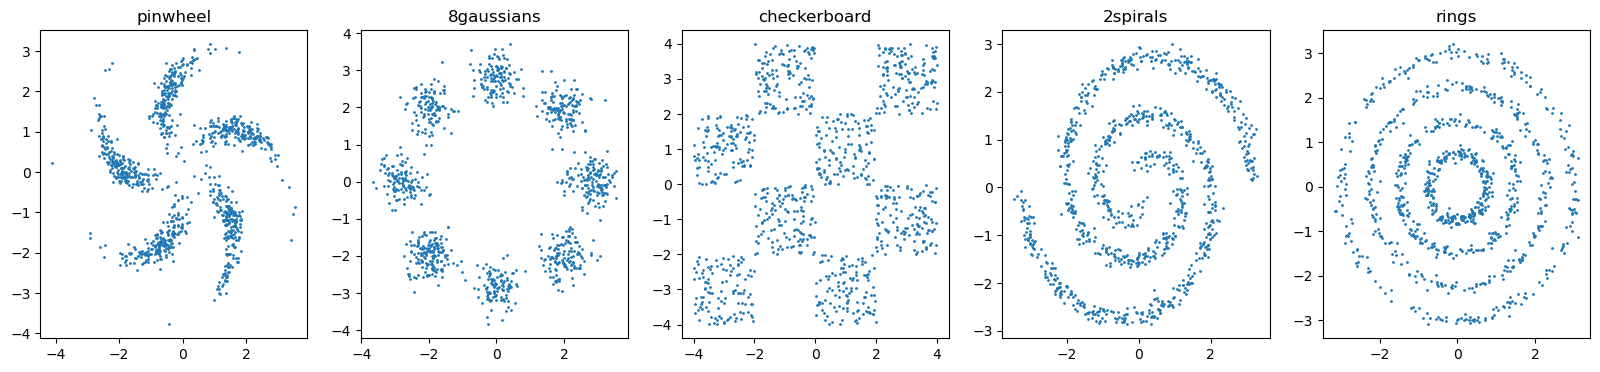

In [2]:
from toy_data import toy_dataset
from toy_data import vis_nce

### Feel free to try out other datasets
datasets = ['pinwheel', '8gaussians', 'checkerboard', '2spirals', 'rings']

### Plot samples from the training set
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, dataset_name in enumerate(datasets):
    X_train = toy_dataset.return_dataset(dataset_name, 1000)[0]
    toy_dataset.plot_2d_samples(ax[i], X_train[:][0])
    ax[i].set_title(dataset_name)
plt.show()

Now we need to define the MLP model. The MLP model should take a 2D input and output a single value, which is the energy of the corresponding input. The architecture is partially defined in the default values of arguments. Specifically, the model should have:
- 2 hidden layers with 100 units each,
- ReLU activation function for hidden layers,
- Linear activation function for the output layer.


In [3]:
### Define the model
class MLP(torch.nn.Module):
    def __init__(self, input_dim:int=2, hidden_dims:tuple=(100, 100), output_dim:int=1):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dims[1], output_dim),
        )
        
    def forward(self, x):
        return self.net(x)

Now we need to right the Langevin sampling method. The accept-reject step is ignored, which means the actual algorithm is the Unjusted Langevin Algorithm (ULA). The algorithm should take the following arguments:
- `x0`: the input data as the initial states,
- `model`: the MLP model,
- `stepsize`: the stepsize of the Langevin dynamics,
- `n_steps`: the number of steps of the Langevin dynamics,
- `noise_scale`: the scale of the noise added to the Langevin dynamics (you can just use the default).

In [4]:
def sample_langevin(x0: torch.Tensor, model: nn.Module, stepsize: float, n_steps: int, noise_scale:float=None, intermediate_samples=False, inverse=False):
    """Draw samples using Langevin dynamics
    x0: torch.Tensor, initial points
    model: An energy-based model
    noise_scale: Optional. float. If None, set to np.sqrt(stepsize * 2)
    """
    if noise_scale is None:
        noise_scale = np.sqrt(stepsize * 2)

    x = x0
    x.requires_grad = True
    l_samples = [x.detach().to('cpu')]
    l_dynamics = []
    for _ in range(n_steps):
        noise = torch.randn_like(x) * noise_scale
        out = model(x)
        grad = autograd.grad(out.sum(), x, only_inputs=True)[0]
        dynamics = (- stepsize * grad + noise) * (-1 if inverse else 1)
        x = x + dynamics
        l_samples.append(x.detach().to('cpu'))
        l_dynamics.append(dynamics.detach().to('cpu'))

    if intermediate_samples:
        return l_samples, l_dynamics
    else:
        return l_samples[-1]

We can test our Langevin sampler by drawing samples from a Gaussian distribution and checking the intermediate samples and dynamics. We can use the negative log probability as the energy.

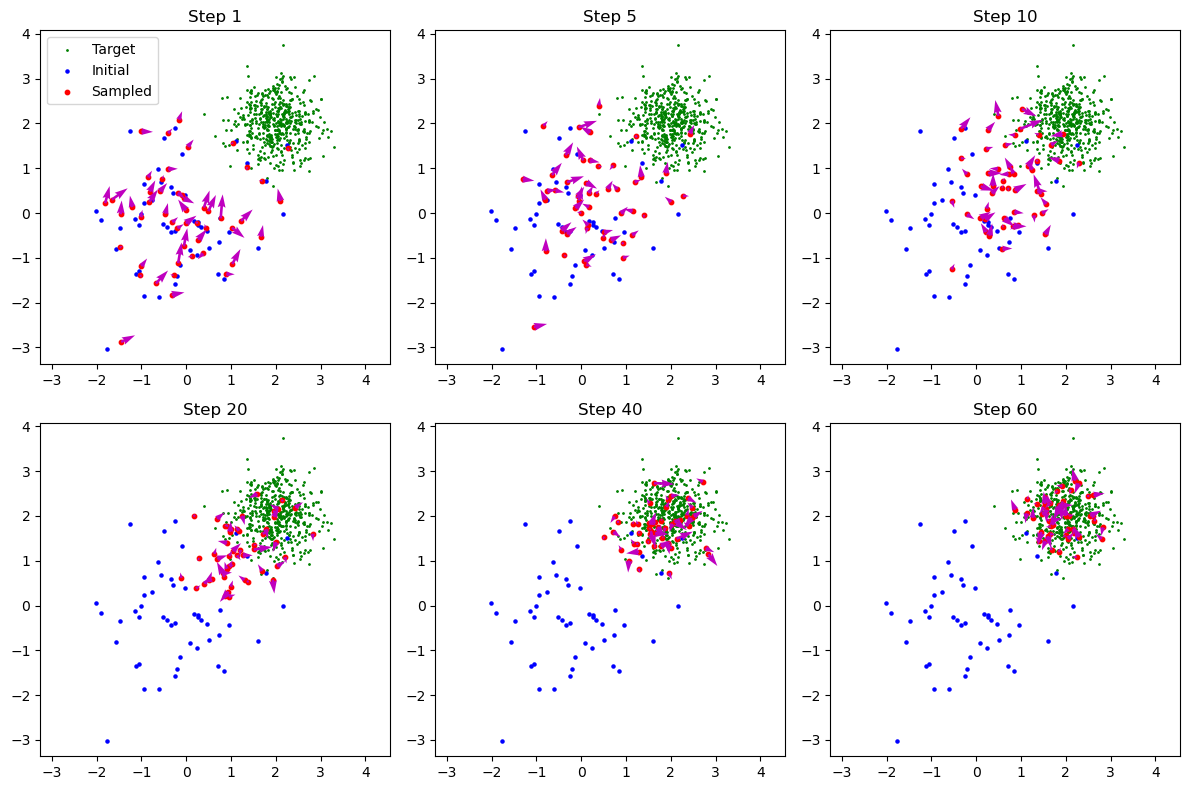

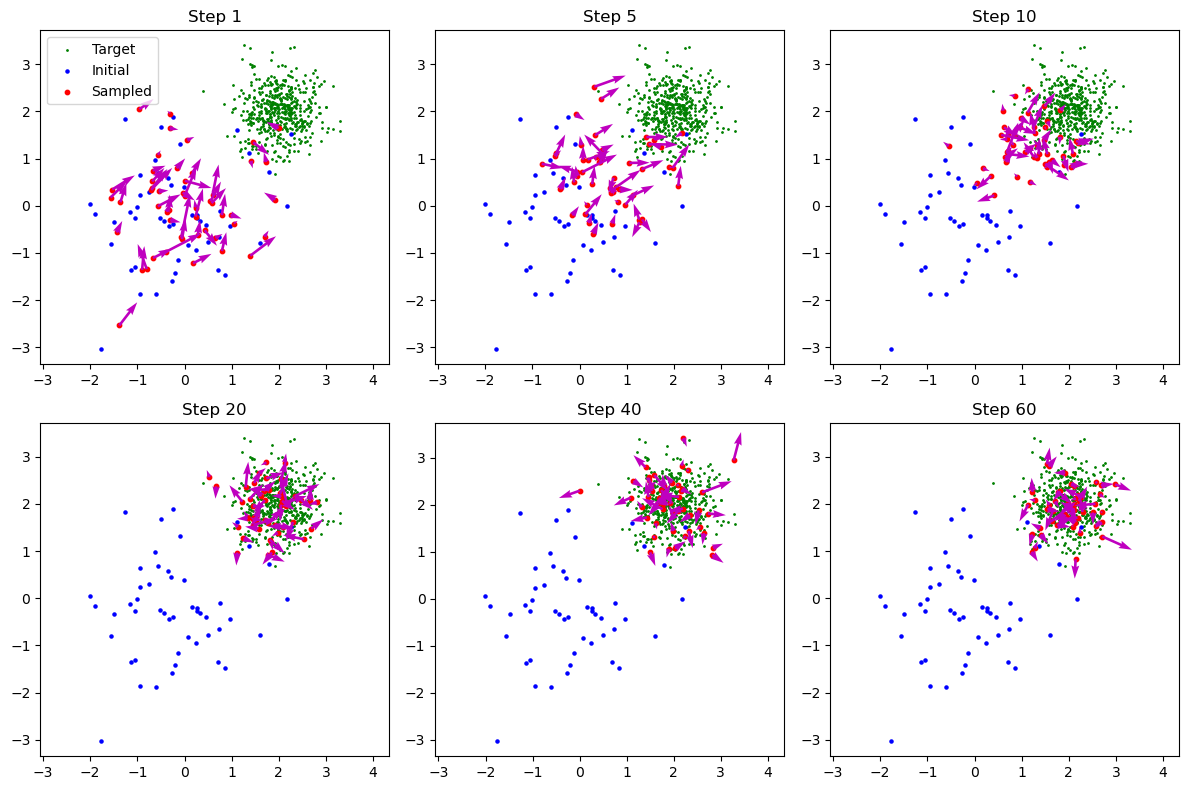

In [5]:
init_states = torch.randn(50, 2)
def langevin_test(init_states, step_size:float=0.01):
    def target_two_dim_gaussian():
        return torch.distributions.MultivariateNormal(2*torch.ones(2), 0.2*torch.eye(2))

    def energy_temp(x):
        return - target_two_dim_gaussian().log_prob(x)

    real_samples = target_two_dim_gaussian().sample((500,))
    l_samples, l_dynamics = sample_langevin(init_states, energy_temp, step_size, 100, intermediate_samples=True)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax_list = axes.flatten()
    ckp_list = [1, 5, 10, 20, 40, 60]
    for i, ckp in enumerate(ckp_list):
        ax_list[i].scatter(real_samples[:, 0], real_samples[:, 1], s=1, c='g', label='Target')
        ax_list[i].scatter(l_samples[0][:, 0], l_samples[0][:, 1], s=5, c='b', label='Initial')
        ax_list[i].scatter(l_samples[ckp][:, 0], l_samples[ckp][:, 1], s=10, c='r', label='Sampled')
        toy_dataset.plot_2d_samples_with_langevin_dynamics(ax_list[i], l_samples[ckp], l_dynamics[ckp-1])
        ax_list[i].set_title(f'Step {ckp}')
    [ax.axis('equal') for ax in ax_list]
    ax_list[0].legend()
    fig.tight_layout()
    plt.show()

langevin_test(init_states, step_size=0.01)
langevin_test(init_states, step_size=0.02)


Now we have implemented the ULA. We can use it to train the model. One last thing we need to do is to define the loss function. The loss function should take the following arguments:
- `energy_positive`: the energy of the positive samples (data),
- `energy_negative`: the energy of the negative samples (samples from the model),
- `alpha`: the L2 regularization parameter, to limit the energy values.

Then, we are ready to train our EBM on the toy dataset "8gaussians"!

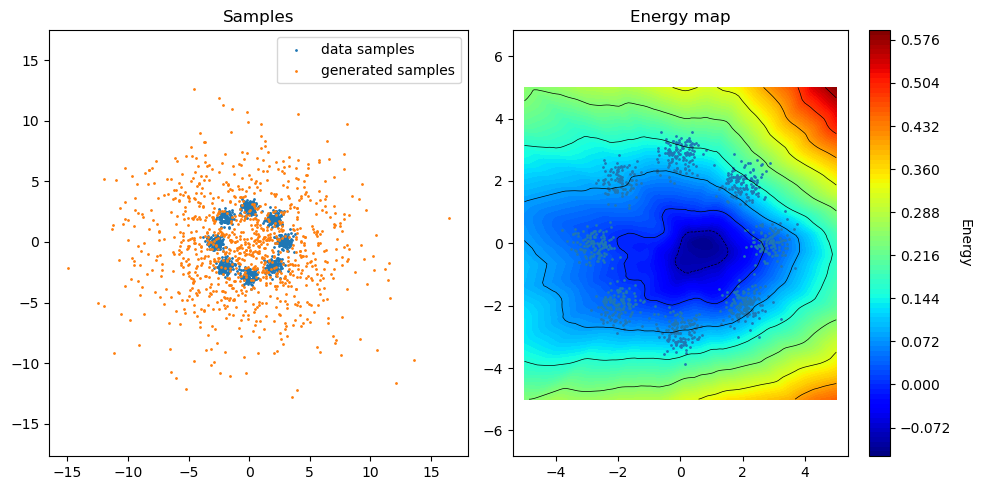

Epoch 1/50. Mean loss -0.2073
Epoch 2/50. Mean loss -0.2421
Epoch 3/50. Mean loss -0.3194
Epoch 4/50. Mean loss -0.2989
Epoch 5/50. Mean loss -0.3692
Epoch 6/50. Mean loss -0.3802
Epoch 7/50. Mean loss -0.3353
Epoch 8/50. Mean loss -0.3254
Epoch 9/50. Mean loss -0.2787
Epoch 10/50. Mean loss -0.3098


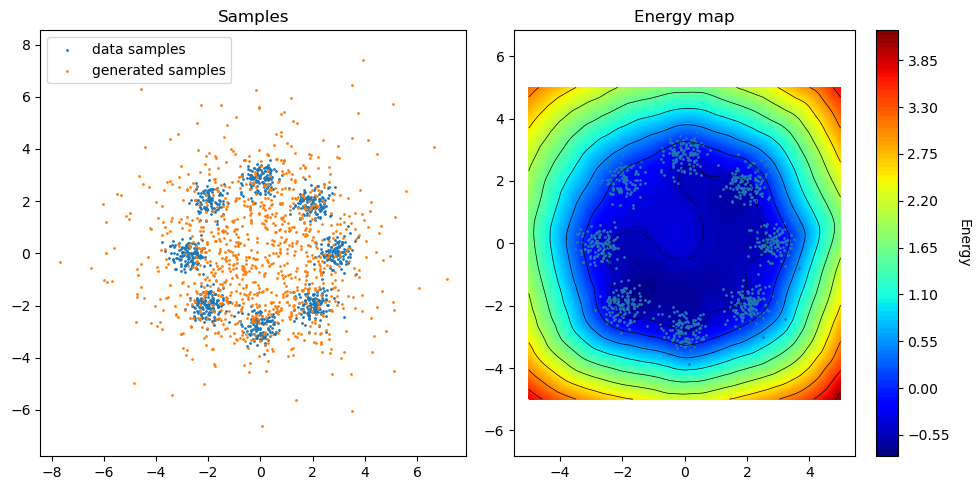

Epoch 11/50. Mean loss -0.3115
Epoch 12/50. Mean loss -0.3517
Epoch 13/50. Mean loss -0.2811
Epoch 14/50. Mean loss -0.3231
Epoch 15/50. Mean loss -0.3303
Epoch 16/50. Mean loss -0.3647
Epoch 17/50. Mean loss -0.3618
Epoch 18/50. Mean loss -0.3781
Epoch 19/50. Mean loss -0.4076
Epoch 20/50. Mean loss -0.4139


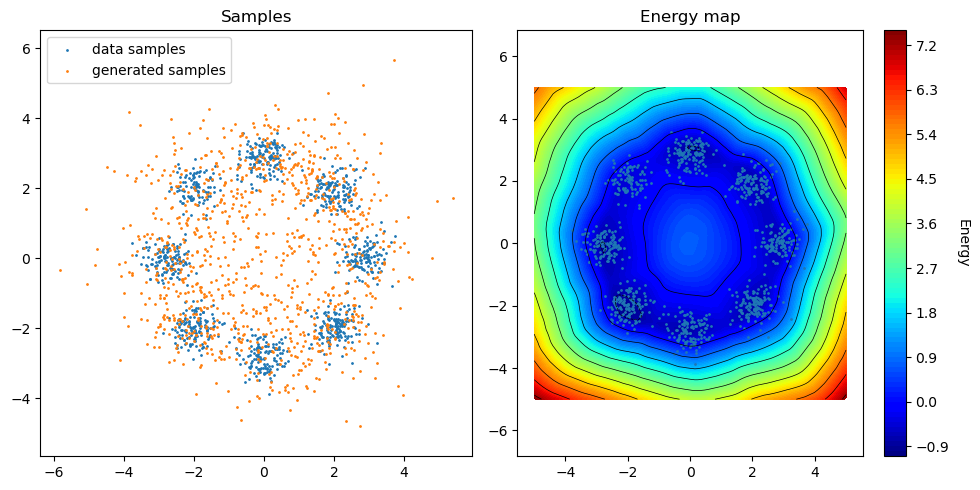

Epoch 21/50. Mean loss -0.4588
Epoch 22/50. Mean loss -0.4609
Epoch 23/50. Mean loss -0.4482
Epoch 24/50. Mean loss -0.4693
Epoch 25/50. Mean loss -0.456
Epoch 26/50. Mean loss -0.4645
Epoch 27/50. Mean loss -0.4793
Epoch 28/50. Mean loss -0.5297
Epoch 29/50. Mean loss -0.4816
Epoch 30/50. Mean loss -0.4801


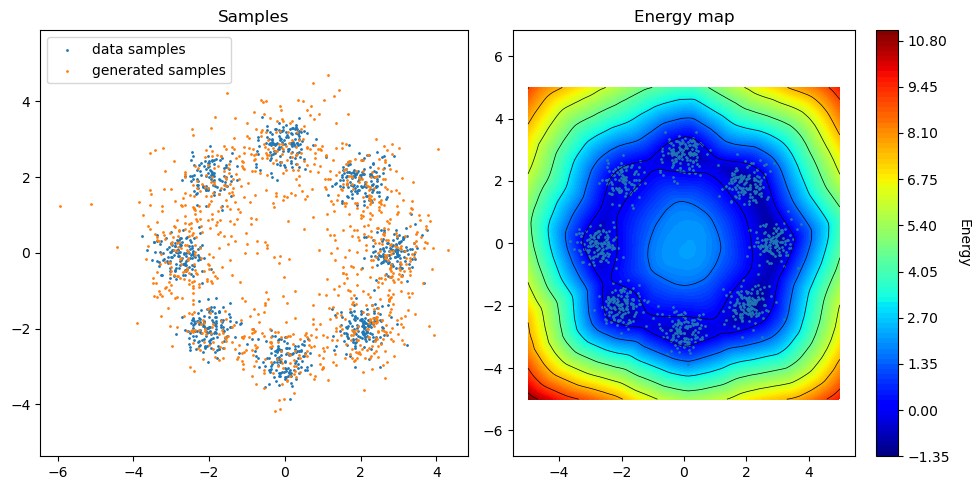

Epoch 31/50. Mean loss -0.4816
Epoch 32/50. Mean loss -0.4986
Epoch 33/50. Mean loss -0.5095
Epoch 34/50. Mean loss -0.514
Epoch 35/50. Mean loss -0.5508
Epoch 36/50. Mean loss -0.5667
Epoch 37/50. Mean loss -0.4941
Epoch 38/50. Mean loss -0.5268
Epoch 39/50. Mean loss -0.5177
Epoch 40/50. Mean loss -0.5043


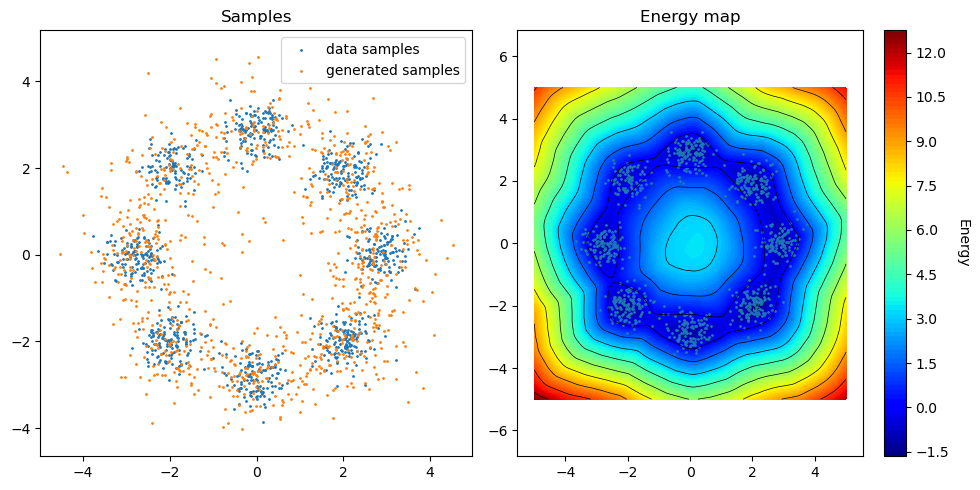

Epoch 41/50. Mean loss -0.5643
Epoch 42/50. Mean loss -0.5189
Epoch 43/50. Mean loss -0.4984
Epoch 44/50. Mean loss -0.5614
Epoch 45/50. Mean loss -0.483
Epoch 46/50. Mean loss -0.5654
Epoch 47/50. Mean loss -0.5496
Epoch 48/50. Mean loss -0.4882
Epoch 49/50. Mean loss -0.5228
Epoch 50/50. Mean loss -0.5605


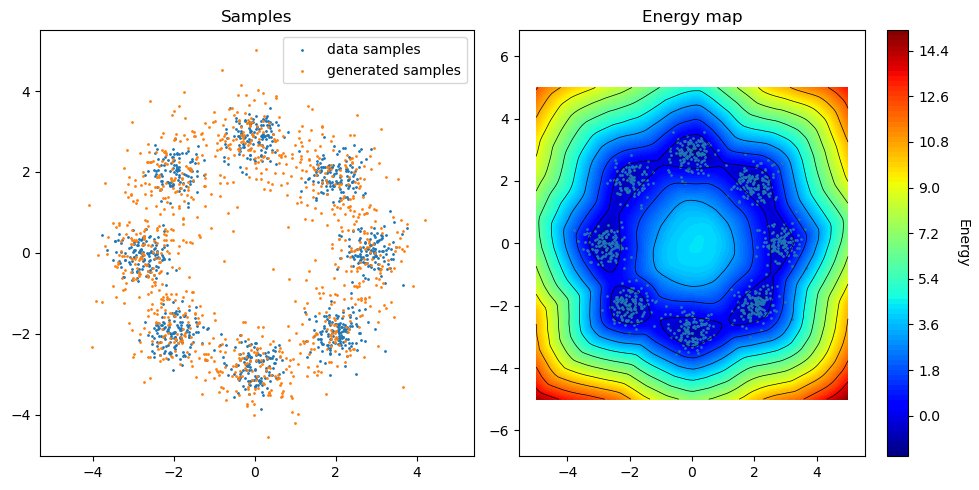

In [6]:
def mle_loss_function(energy_pos, energy_neg, alpha:float=0.1):
    loss = (energy_pos - energy_neg) + alpha * (energy_pos ** 2 + energy_neg ** 2)
    loss = loss.mean()
    
    return loss

### Load the training set
X_train = toy_dataset.return_dataset('8gaussians', 1000)[0]
dl_train = DataLoader(X_train, batch_size=128, shuffle=True, num_workers=8)

### Define the training parameters
n_epoch = 50     # number of epochs
stepsize = 0.1   # Langevin dynamics step size
n_step = 100     # The number of Langevin dynamics steps
alpha = 0.1      # Regularizer coefficient
batch_size = 128 # Batch size

model = MLP().to(device)
opt = Adam(model.parameters(), lr=1e-3)

X = torch.randn(1000, 2).to(device)
X = sample_langevin(X, model, stepsize, n_step, intermediate_samples=False).to('cpu').detach()
toy_dataset.vis_result(X_train, X, model, device=device)

for i_epoch in range(n_epoch):
        l_loss = []
        for pos_x, in dl_train:
            
            pos_x:torch.Tensor = pos_x.to(device)

            ### NOTE: YOUR CODE HERE
            neg_x = torch.randn_like(pos_x).to(device)
            neg_x = sample_langevin(neg_x, model, stepsize, n_step, intermediate_samples=False)
            neg_x = neg_x.to(device)
            
            pos_out:torch.Tensor = model(pos_x)
            neg_out:torch.Tensor = model(neg_x)
            
            loss = (pos_out - neg_out) + alpha * (pos_out ** 2 + neg_out ** 2)
            loss = loss.mean()

            opt.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            opt.step()
            
            l_loss.append(loss.item())
        print(f'Epoch {i_epoch+1}/{n_epoch}. Mean loss {round(np.mean(l_loss), 4)}')

        ### Visualize the results every 10 epochs
        if ((i_epoch+1) % 10 == 0):
            X = torch.randn(1000, 2).to(device)
            X = sample_langevin(X, model, stepsize, n_step, intermediate_samples=False).to('cpu').detach()
            toy_dataset.vis_result(X_train, X, model, device=device)

## Session 2: NCE and cNCE

Now we switch to different ways to train our EBMs. First of all, we will use the NCE method to train our EBM, for which we need to use a different network architecture. The difference here is that we need to model the partition function as a learnable parameter. Feel free to use any architecture you like. Why is it important to model the partition function as a learnable parameter?

In [8]:
class MLPC(nn.Module):
    def __init__(self, x_dim):
        """
        Initialize EBM model, which is an MLP with additional estimated partition function c.

        Args:
            x_dim (int): The size of the input data.
        """

        super(MLPC, self).__init__()

        self.c = nn.Parameter(torch.tensor([1.], requires_grad=True))

        self.net = nn.Sequential(
            nn.Linear(x_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        log_p = - self.net(x) - self.c
        return log_p
    
### Test the model
batch_size = 16
x_dim = 10
x_rand = torch.randn((batch_size, x_dim))
ebm = MLPC(x_dim)
assert ebm(x_rand).shape == (batch_size, 1), "Generator output shape is wrong"

Let's define a noise distribution. Write code for your noise distribution. Could be any distribution of your choice. Looking into `torch.distributions` could be a good idea. The argument `params` depends on which distribution you chose. First recall what should be considered when selecting an appropriate noise distribution:

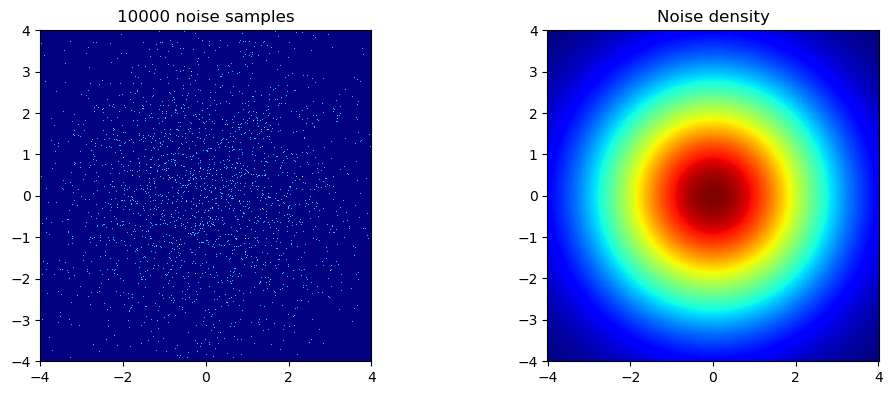

In [10]:
class NoiseDistribution:
    def __init__(self, x_dim, params) -> None:
        self.distribution = torch.distributions.MultivariateNormal(torch.zeros(x_dim).to(device), params[0]*torch.eye(x_dim).to(device))
        
    def sample(self, n_samples):
        '''
        returns n_samples from the distribution
        '''
        return self.distribution.sample((n_samples,))
    
    def log_prob(self, x):
        '''
        returns the log_probability of a batch of samples
        '''
        return self.distribution.log_prob(x).unsqueeze(1)
    

### Look at your noise
batch_size = 10000
x_dim = 2
distribution_params = [4] # TODO, depends on which distribution you use.
plot_lim = 4 # for plot, may need to be adjusted depending on your noise dist parameters
n_pts = 700 # for plot 2D hist bins
noise_dist = NoiseDistribution(x_dim, distribution_params)
noise_samples = noise_dist.sample(batch_size)

assert noise_samples.shape == (batch_size, x_dim), "Noise distribution samples shapes are wrong"

log_probs = noise_dist.log_prob(noise_samples)
assert log_probs.shape == (batch_size, 1), "Noise distribution samples shapes are wrong"

# plot samples and pdf
fig, axs = plt.subplots(1, 2, figsize=(12,4.3), subplot_kw={'aspect': 'equal'})
vis_nce.plot_samples(noise_samples, axs[0], plot_lim, n_pts)
axs[0].set_title(f'{batch_size} noise samples')
test_grid = vis_nce.setup_grid(plot_lim, n_pts, device)
vis_nce.plot_noise(noise_dist, axs[1], test_grid, n_pts)

Now that we have coded an EBM model and a noise distribution of your choice, it is time to code the noise contrastive estimator (NCE). 

Describe the idea of the NCE and why it is useful. 
What is the purpose of using the parameter `k`?

In [13]:
class NCE:
    def __init__(self, ebm, noise_dist, k) -> None:
        """
        Initializes the NCE
        
        Args:
        ebm (EBM): The energy based model.
        noise_dist (torch.distributions.distribution): The noise distribution. Could be from torch.distributions. Can also be some custom distribution.
        k (int): The nr of noise data points for each target data point. \nu in the slides from lecture.
        """
        self.ebm = ebm
        self.noise_dist = noise_dist 
        self.k = k

    def loss(self, x) -> torch.Tensor:
        '''
        returns the NCE-loss given a batch x from the dataset
        '''
        noise = self.noise_dist.sample(self.k*x.shape[0])
        log_px = self.ebm(x)
        log_pnoise = self.ebm(noise)
        log_qx = self.noise_dist.log_prob(x)
        log_qnoise = self.noise_dist.log_prob(noise)
        
        value_data = log_px - torch.logsumexp(torch.cat([log_px, log_qx], dim=1), dim=1, keepdim=True)  # logp(x)/(logp(x) + logq(x))
        value_gen = log_qnoise - torch.logsumexp(torch.cat([log_pnoise, log_qnoise], dim=1), dim=1, keepdim=True)  # logq(x̃)/(logp(x̃) + logq(x̃))
        nce_loss = -(torch.mean(value_data) + self.k*torch.mean(value_gen))

        return nce_loss
    

### Test the NCE loss
x_dim = 2
x_rand = torch.randn((batch_size, x_dim)).to(device)
k = 5
distribution_params = [4] # TODO, depends on which distribution you use.

ebm = MLPC(x_dim=x_dim).to(device)
noise_dist = NoiseDistribution(x_dim, distribution_params)
nce = NCE(ebm, noise_dist, k)
loss = nce.loss(x_rand)
# Assert scalar
assert loss.shape == torch.Size([]), "Loss shape is wrong"

In [14]:
def train(epoch, train_loader, ebm, optimizer, nce):
    ebm.train()
    train_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()

        loss = nce.loss(x)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(x),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(x),
                )
            )
    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )
    return train_loss / len(train_loader.dataset)

def test(test_loader, ebm, nce):
    ebm.eval()
    test_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device)

            # sum up batch loss
            test_loss += nce.loss(x).item()

    test_loss /= len(test_loader.dataset)

    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss

The cell below will train an EBM with NCE on the selected generated dataset.

Feel free to explore the usage of the different datasets available and how the learning differs for different values of k and the noise distribution parameters.

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.129651
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.041282
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.024881
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.021600
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.020296
Train Epoch: 1 [6400/8000 (79%)]	Loss: 0.020200
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.020070
====> Epoch: 1 Average loss: 0.0293
====> Test set loss: 0.0202
Saving image to images/....


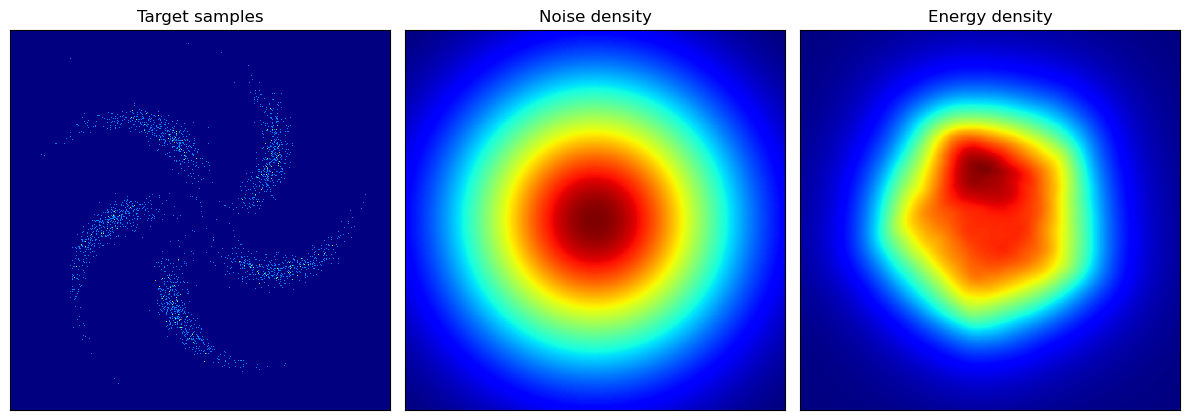

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.019631
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.019327
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.018958
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.018468
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.018322
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.017210
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.017684
====> Epoch: 2 Average loss: 0.0186
====> Test set loss: 0.0175
Saving image to images/....


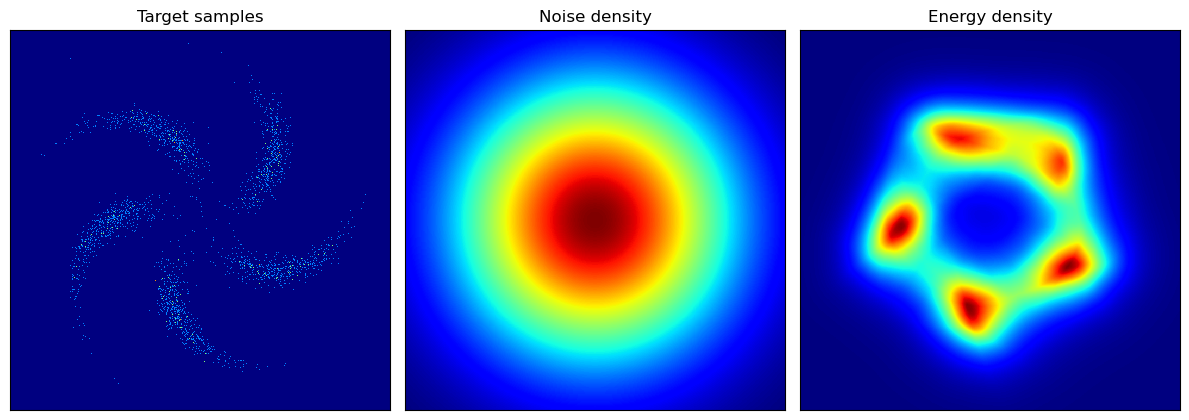

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.017230
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.017126
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.017435
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.016351
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.016198
Train Epoch: 3 [6400/8000 (79%)]	Loss: 0.014931
Train Epoch: 3 [7680/8000 (95%)]	Loss: 0.016093
====> Epoch: 3 Average loss: 0.0166
====> Test set loss: 0.0161
Saving image to images/....


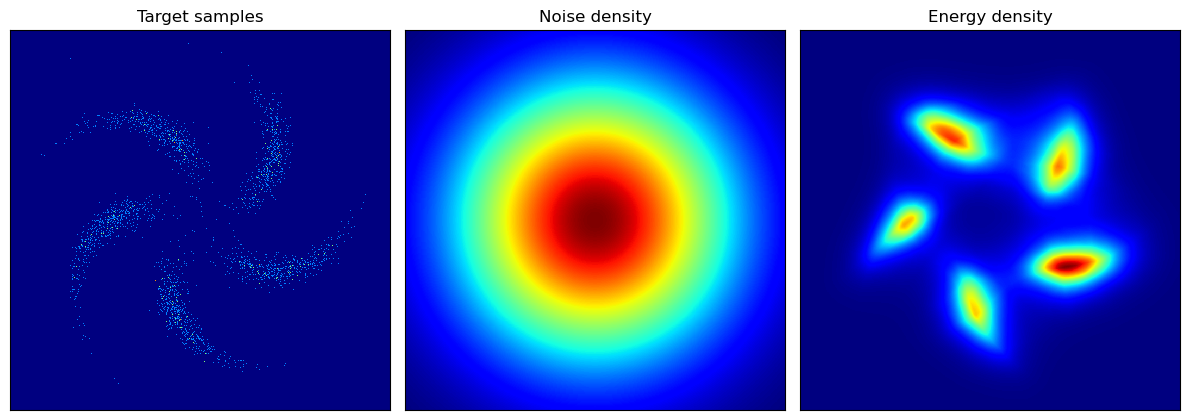

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.015595
Train Epoch: 4 [1280/8000 (16%)]	Loss: 0.015529
Train Epoch: 4 [2560/8000 (32%)]	Loss: 0.016886
Train Epoch: 4 [3840/8000 (48%)]	Loss: 0.015242
Train Epoch: 4 [5120/8000 (63%)]	Loss: 0.014774
Train Epoch: 4 [6400/8000 (79%)]	Loss: 0.015235
Train Epoch: 4 [7680/8000 (95%)]	Loss: 0.014703
====> Epoch: 4 Average loss: 0.0154
====> Test set loss: 0.0149
Saving image to images/....


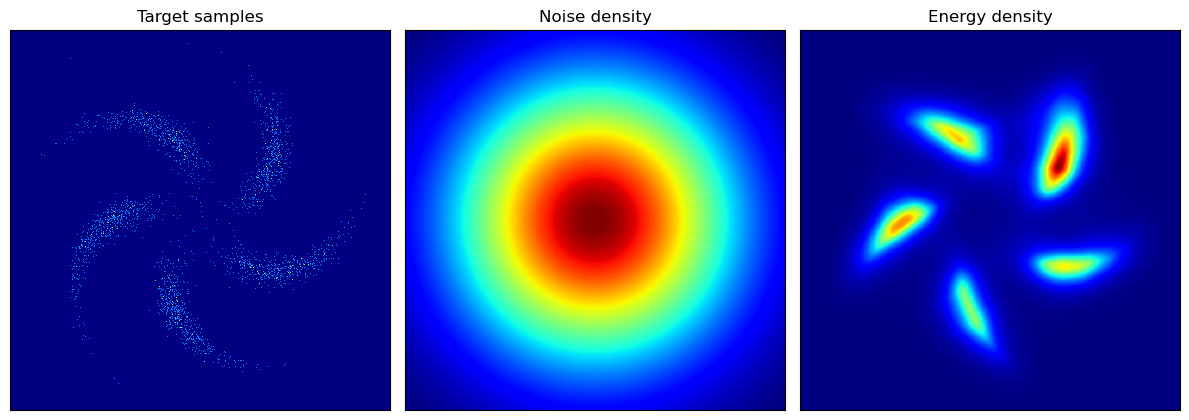

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.013940
Train Epoch: 5 [1280/8000 (16%)]	Loss: 0.014082
Train Epoch: 5 [2560/8000 (32%)]	Loss: 0.015288
Train Epoch: 5 [3840/8000 (48%)]	Loss: 0.014155
Train Epoch: 5 [5120/8000 (63%)]	Loss: 0.013241
Train Epoch: 5 [6400/8000 (79%)]	Loss: 0.013374
Train Epoch: 5 [7680/8000 (95%)]	Loss: 0.014236
====> Epoch: 5 Average loss: 0.0145
====> Test set loss: 0.0143
Saving image to images/....


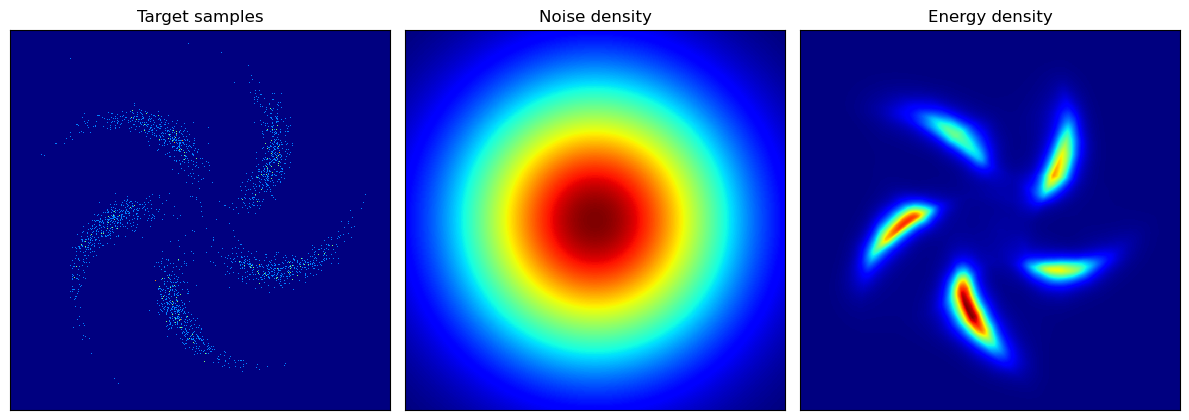

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.013152
Train Epoch: 6 [1280/8000 (16%)]	Loss: 0.013899
Train Epoch: 6 [2560/8000 (32%)]	Loss: 0.013711
Train Epoch: 6 [3840/8000 (48%)]	Loss: 0.015349
Train Epoch: 6 [5120/8000 (63%)]	Loss: 0.013741
Train Epoch: 6 [6400/8000 (79%)]	Loss: 0.013425
Train Epoch: 6 [7680/8000 (95%)]	Loss: 0.014942
====> Epoch: 6 Average loss: 0.0140
====> Test set loss: 0.0138
Saving image to images/....


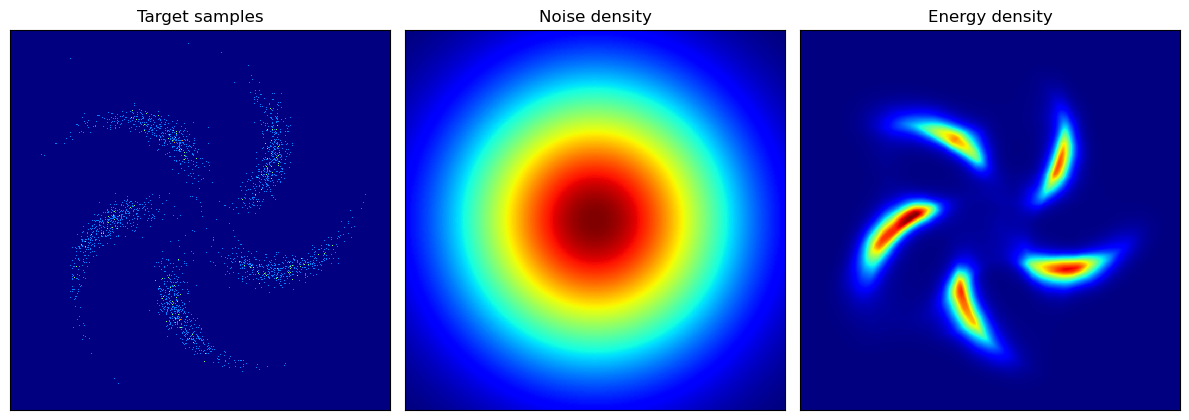

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.014517
Train Epoch: 7 [1280/8000 (16%)]	Loss: 0.013025
Train Epoch: 7 [2560/8000 (32%)]	Loss: 0.013417
Train Epoch: 7 [3840/8000 (48%)]	Loss: 0.013559
Train Epoch: 7 [5120/8000 (63%)]	Loss: 0.014259
Train Epoch: 7 [6400/8000 (79%)]	Loss: 0.013393
Train Epoch: 7 [7680/8000 (95%)]	Loss: 0.013067
====> Epoch: 7 Average loss: 0.0137
====> Test set loss: 0.0137
Saving image to images/....


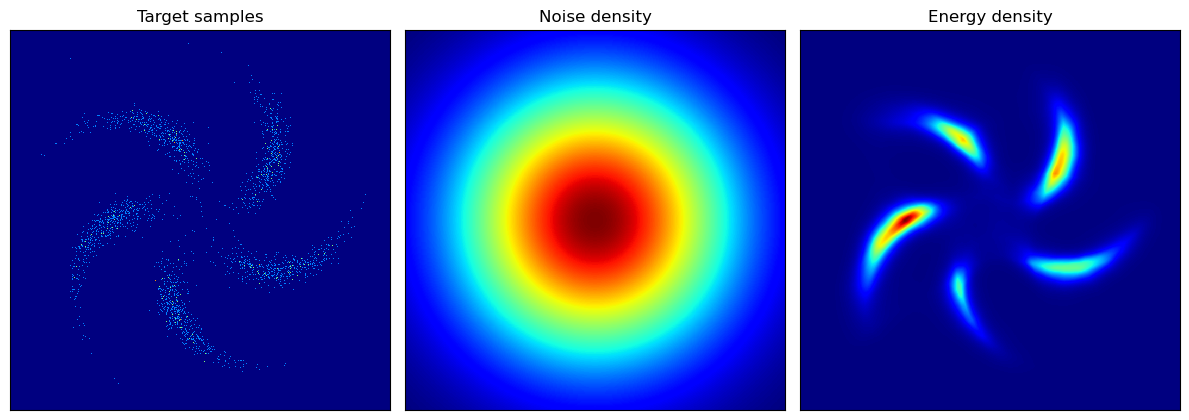

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.012904
Train Epoch: 8 [1280/8000 (16%)]	Loss: 0.013689
Train Epoch: 8 [2560/8000 (32%)]	Loss: 0.013678
Train Epoch: 8 [3840/8000 (48%)]	Loss: 0.012580
Train Epoch: 8 [5120/8000 (63%)]	Loss: 0.011837
Train Epoch: 8 [6400/8000 (79%)]	Loss: 0.012838
Train Epoch: 8 [7680/8000 (95%)]	Loss: 0.013212
====> Epoch: 8 Average loss: 0.0134
====> Test set loss: 0.0138
Saving image to images/....


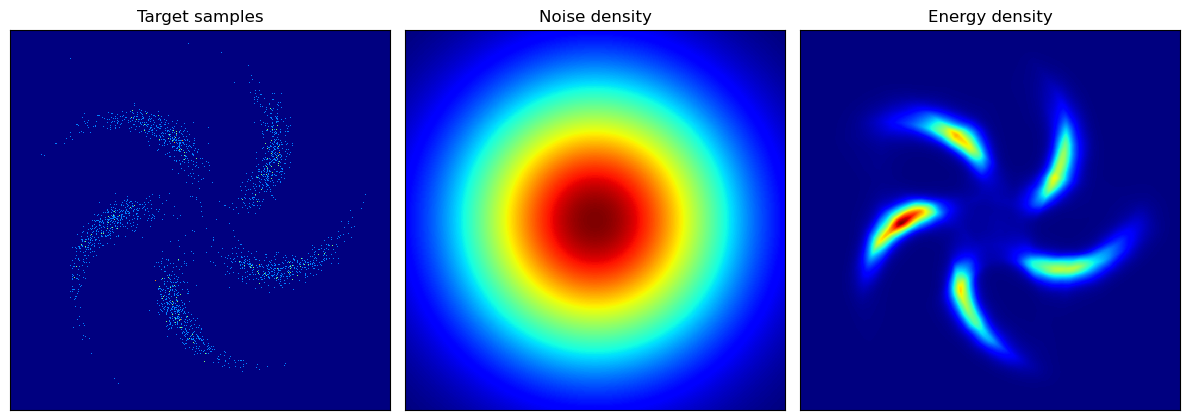

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.014391
Train Epoch: 9 [1280/8000 (16%)]	Loss: 0.013207
Train Epoch: 9 [2560/8000 (32%)]	Loss: 0.011278
Train Epoch: 9 [3840/8000 (48%)]	Loss: 0.012601
Train Epoch: 9 [5120/8000 (63%)]	Loss: 0.012927
Train Epoch: 9 [6400/8000 (79%)]	Loss: 0.013083
Train Epoch: 9 [7680/8000 (95%)]	Loss: 0.013114
====> Epoch: 9 Average loss: 0.0132
====> Test set loss: 0.0134
Saving image to images/....


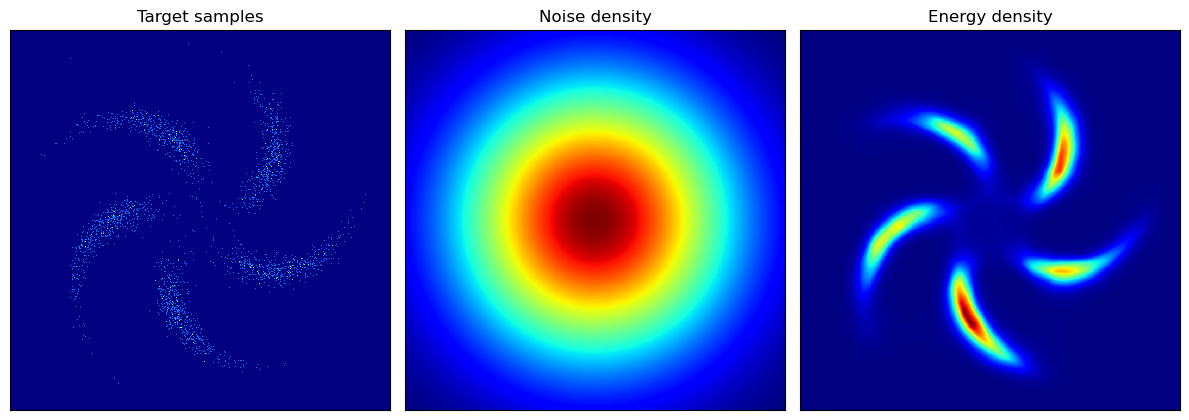

Time elapsed during training: 0 minutes and 43 seconds


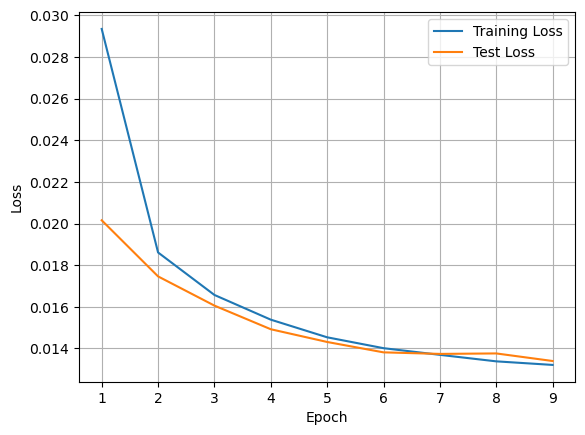

In [17]:
# Specify parameters
n_epochs = 10
batch_size = 128
train_size = 0.8
n_samples = 10_000
distribution_params = [4]
k = 5
x_dim = 2
training_losses = np.zeros([n_epochs, 1])
test_losses = np.zeros([n_epochs, 1])
dataset_name = 'pinwheel' # one of '8gaussians', 'checkerboard', '2spirals', 'pinwheel'
results_dir = f'results/NCE/{dataset_name}'

os.makedirs(results_dir, exist_ok=True)
os.makedirs('models', exist_ok=True)

# Load generated data and create dataloaders
train_dataset = toy_dataset.return_dataset(dataset_name, int(train_size*n_samples))[0][:][0]
test_dataset  = toy_dataset.return_dataset(dataset_name, n_samples-int(train_size*n_samples))[0][:][0]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Build model
ebm = MLPC(x_dim).to(device)
# Use defined noise dist
noise_dist = NoiseDistribution(x_dim, distribution_params)
# Build NCE
nce = NCE(ebm, noise_dist, k)
optimizer = Adam(ebm.parameters())

# Perform training
start_time = time.time()
best_loss = torch.inf
for epoch in range(1, n_epochs):
    train_loss = train(epoch, train_dataloader, ebm, optimizer, nce)
    test_loss = test(test_dataloader, ebm, nce)
    if test_loss < best_loss:
        torch.save(ebm, 'models/nce.pt')
        best_loss = test_loss
    training_losses[epoch - 1] = train_loss
    test_losses[epoch - 1] = test_loss
    
    vis_nce.plot_nce(train_dataset, ebm, noise_dist, device, os.path.join(results_dir, f'epoch_{epoch}.png'))

end_time = time.time()
time_elapsed = end_time - start_time
minutes, seconds = divmod(time_elapsed, 60)
print("Time elapsed during training: %d minutes and %d seconds" % (minutes, seconds))

# Plot training and test losses
plt.plot(range(1, n_epochs), training_losses[:-1])
plt.plot(range(1, n_epochs), test_losses[:-1])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"])
plt.savefig(os.path.join(results_dir, 'train_test_loss.png'))

Now we want to also implement the conditional NCE (cNCE). What is considered the advantage of cNCE over NCE? Are there any potential disadvantages?

In [19]:
class cNCE:
    def __init__(self, ebm) -> None:
        """
        Initializes the conditional NCE
        
        Args:
        ebm (EBM): The energy based model.
        noise_dist (torch.distributions.distribution): The noise distribution. Could be from torch.distributions. Can also be some custom distribution.
        """
        self.ebm = ebm
    
    def add_noise(self, x):
        '''
        returns the noised batch x
        '''
        return x + torch.randn_like(x) * 0.3

    def loss(self, x) -> torch.Tensor:
        '''
        returns the cNCE-loss given a batch x from the dataset
        '''
        noise = self.add_noise(x)
        log_px = self.ebm(x)
        log_pnoise = self.ebm(noise)
        
        value = log_px - torch.logsumexp(torch.cat([log_px, log_pnoise], dim=1), dim=1, keepdim=True)  # logp(x)/(logp(x) + logq(x))

        return torch.mean(-value)

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.005415
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.005363
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.005393
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.004911
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.005355
Train Epoch: 1 [6400/8000 (79%)]	Loss: 0.005022
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.004807
====> Epoch: 1 Average loss: 0.0051
====> Test set loss: 0.0049
Saving image to images/....


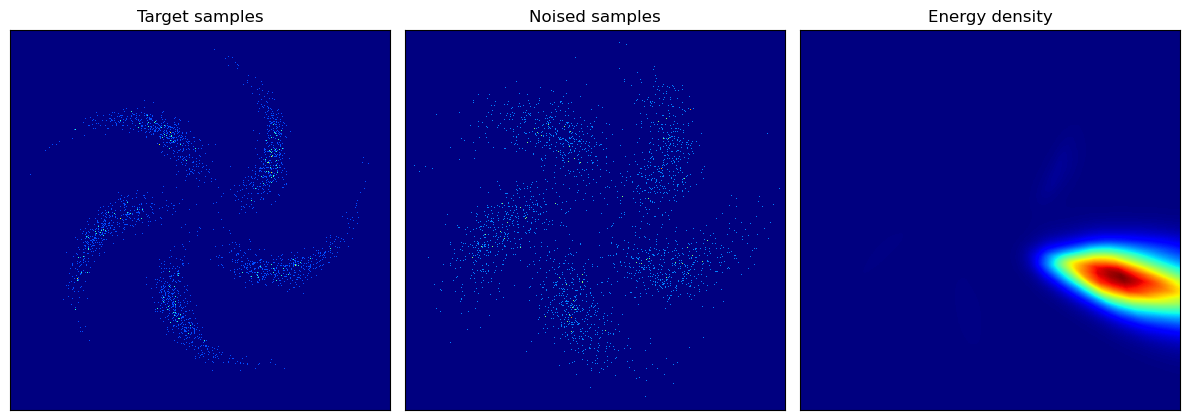

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.004823
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.004306
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.004304
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.004274
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.003825
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.004733
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.004660
====> Epoch: 2 Average loss: 0.0045
====> Test set loss: 0.0046
Saving image to images/....


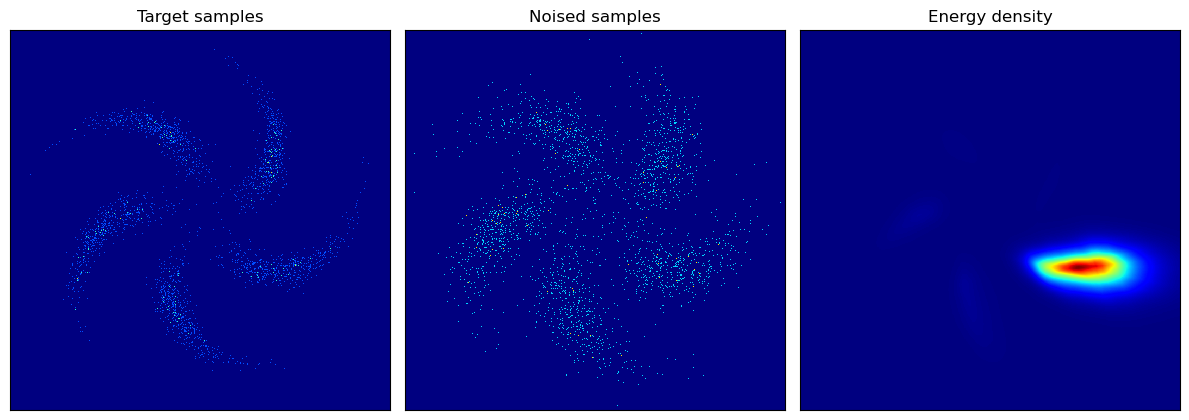

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.004521
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.004595
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.004539
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.004188
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.004527
Train Epoch: 3 [6400/8000 (79%)]	Loss: 0.004049
Train Epoch: 3 [7680/8000 (95%)]	Loss: 0.004518
====> Epoch: 3 Average loss: 0.0044
====> Test set loss: 0.0045
Saving image to images/....


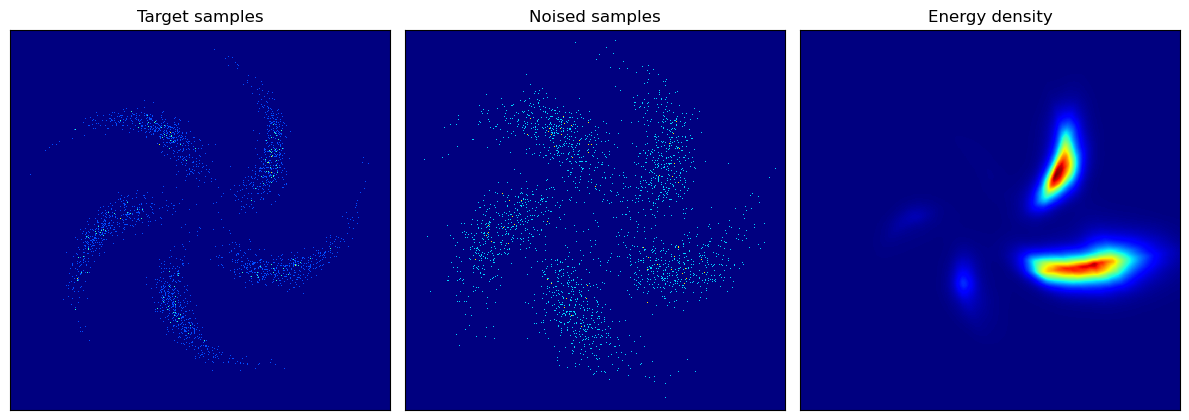

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.004710
Train Epoch: 4 [1280/8000 (16%)]	Loss: 0.004398
Train Epoch: 4 [2560/8000 (32%)]	Loss: 0.004014
Train Epoch: 4 [3840/8000 (48%)]	Loss: 0.004526
Train Epoch: 4 [5120/8000 (63%)]	Loss: 0.004094
Train Epoch: 4 [6400/8000 (79%)]	Loss: 0.004045
Train Epoch: 4 [7680/8000 (95%)]	Loss: 0.004472
====> Epoch: 4 Average loss: 0.0042
====> Test set loss: 0.0042
Saving image to images/....


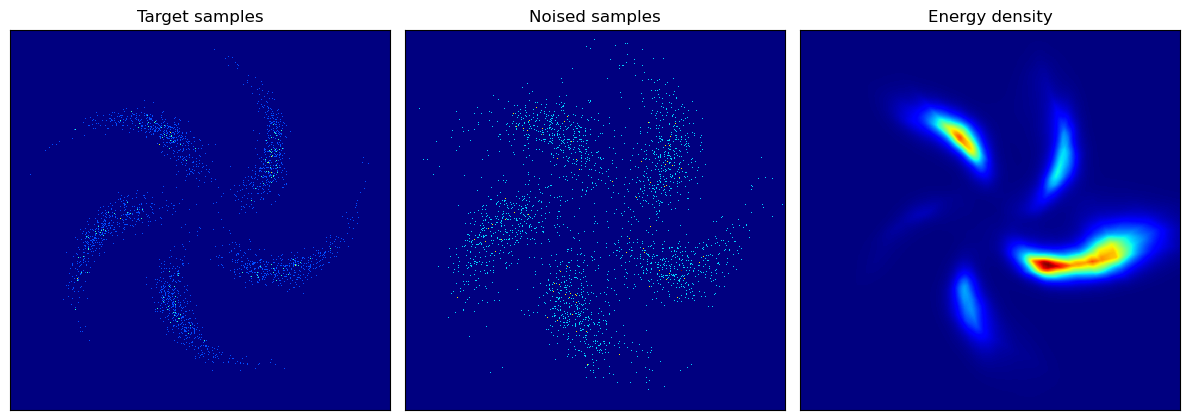

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.004117
Train Epoch: 5 [1280/8000 (16%)]	Loss: 0.004219
Train Epoch: 5 [2560/8000 (32%)]	Loss: 0.004084
Train Epoch: 5 [3840/8000 (48%)]	Loss: 0.004212
Train Epoch: 5 [5120/8000 (63%)]	Loss: 0.004380
Train Epoch: 5 [6400/8000 (79%)]	Loss: 0.004001
Train Epoch: 5 [7680/8000 (95%)]	Loss: 0.003860
====> Epoch: 5 Average loss: 0.0042
====> Test set loss: 0.0040
Saving image to images/....


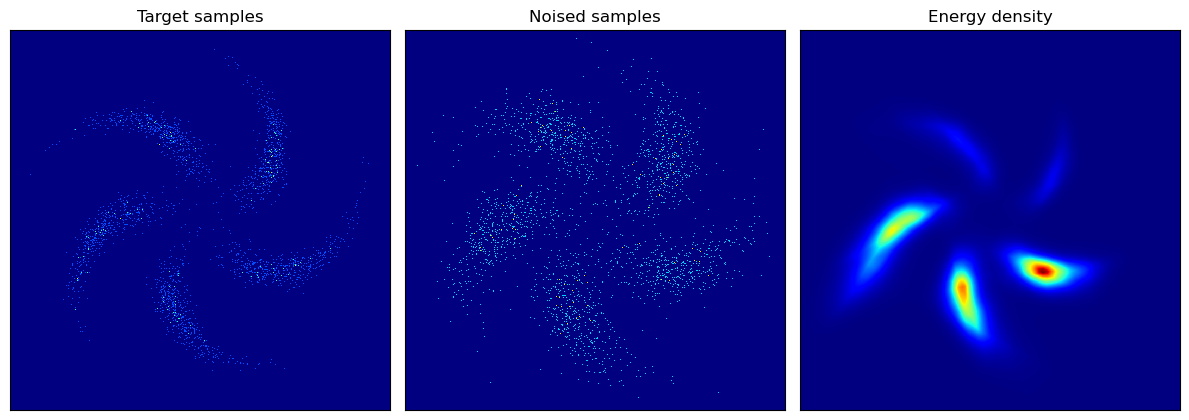

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.003327
Train Epoch: 6 [1280/8000 (16%)]	Loss: 0.003999
Train Epoch: 6 [2560/8000 (32%)]	Loss: 0.004008
Train Epoch: 6 [3840/8000 (48%)]	Loss: 0.003983
Train Epoch: 6 [5120/8000 (63%)]	Loss: 0.004232
Train Epoch: 6 [6400/8000 (79%)]	Loss: 0.003748
Train Epoch: 6 [7680/8000 (95%)]	Loss: 0.004346
====> Epoch: 6 Average loss: 0.0041
====> Test set loss: 0.0040
Saving image to images/....


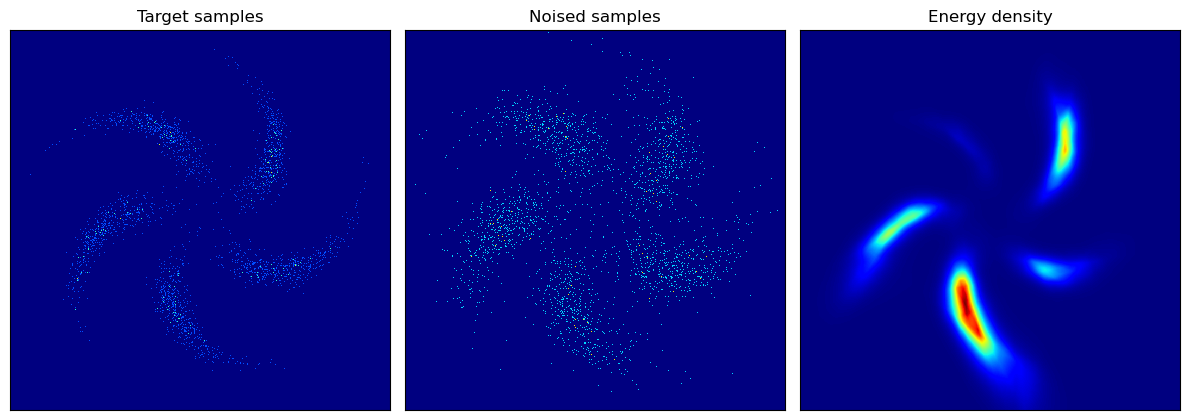

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.003825
Train Epoch: 7 [1280/8000 (16%)]	Loss: 0.003457
Train Epoch: 7 [2560/8000 (32%)]	Loss: 0.003655
Train Epoch: 7 [3840/8000 (48%)]	Loss: 0.004405
Train Epoch: 7 [5120/8000 (63%)]	Loss: 0.004465
Train Epoch: 7 [6400/8000 (79%)]	Loss: 0.003866
Train Epoch: 7 [7680/8000 (95%)]	Loss: 0.004567
====> Epoch: 7 Average loss: 0.0040
====> Test set loss: 0.0040
Saving image to images/....


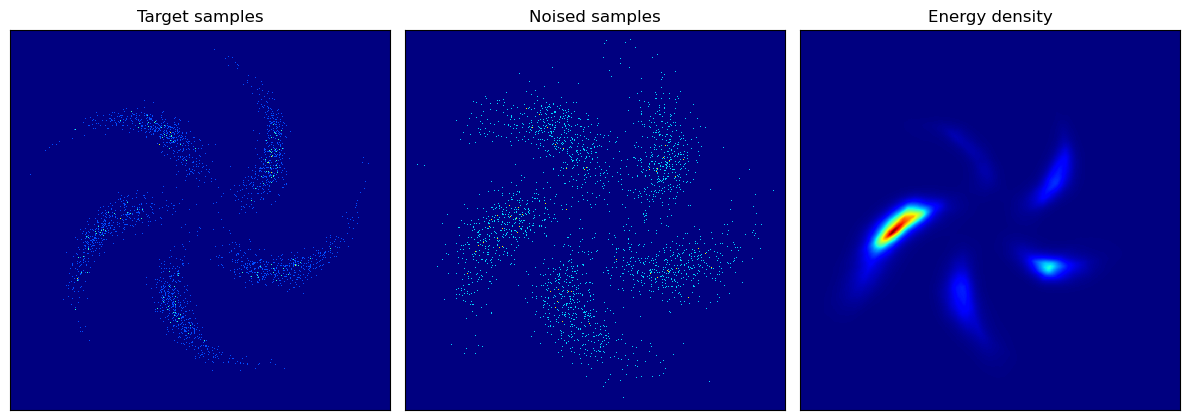

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.004024
Train Epoch: 8 [1280/8000 (16%)]	Loss: 0.003278
Train Epoch: 8 [2560/8000 (32%)]	Loss: 0.003780
Train Epoch: 8 [3840/8000 (48%)]	Loss: 0.004873
Train Epoch: 8 [5120/8000 (63%)]	Loss: 0.004290
Train Epoch: 8 [6400/8000 (79%)]	Loss: 0.003925
Train Epoch: 8 [7680/8000 (95%)]	Loss: 0.003436
====> Epoch: 8 Average loss: 0.0041
====> Test set loss: 0.0040
Saving image to images/....


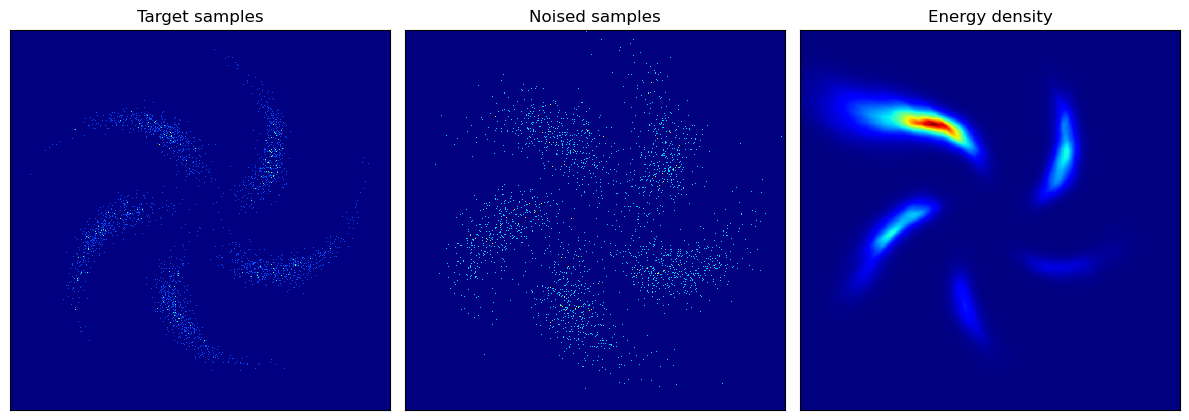

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.003607
Train Epoch: 9 [1280/8000 (16%)]	Loss: 0.003287
Train Epoch: 9 [2560/8000 (32%)]	Loss: 0.004010
Train Epoch: 9 [3840/8000 (48%)]	Loss: 0.004056
Train Epoch: 9 [5120/8000 (63%)]	Loss: 0.004243
Train Epoch: 9 [6400/8000 (79%)]	Loss: 0.003900
Train Epoch: 9 [7680/8000 (95%)]	Loss: 0.003582
====> Epoch: 9 Average loss: 0.0040
====> Test set loss: 0.0040
Saving image to images/....


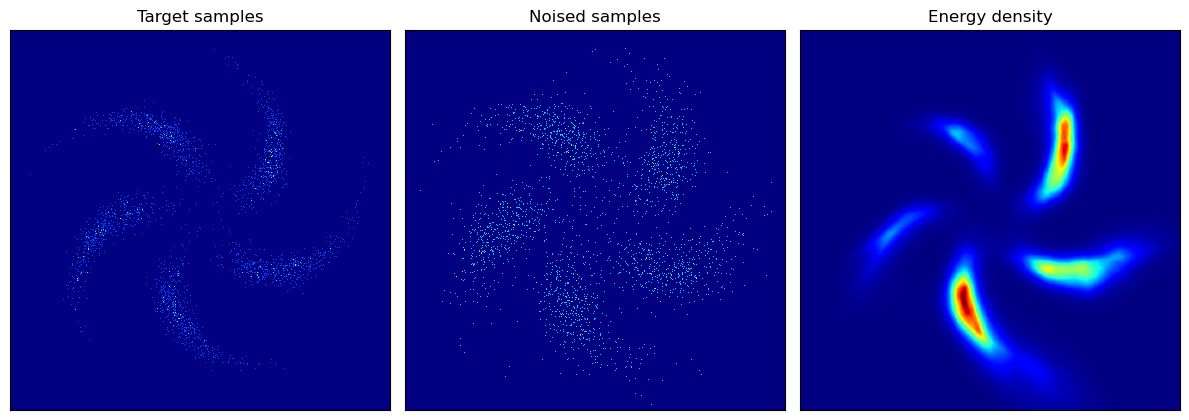

Time elapsed during training: 0 minutes and 39 seconds


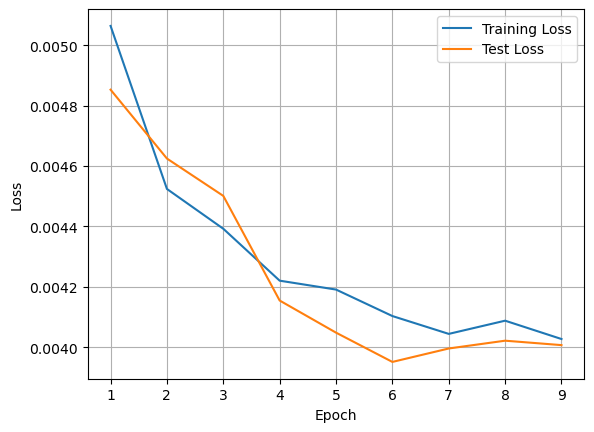

In [20]:
# Specify parameters
n_epochs = 10
batch_size = 128
train_size = 0.8
n_samples = 10_000
x_dim = 2
training_losses = np.zeros([n_epochs, 1])
test_losses = np.zeros([n_epochs, 1])
dataset_name = 'pinwheel' # one of '8gaussians', 'checkerboard', '2spirals', 'pinwheel'
results_dir = f'results/cNCE/{dataset_name}'

os.makedirs(results_dir, exist_ok=True)
os.makedirs('models', exist_ok=True)

# Load generated data and create dataloaders
train_dataset = toy_dataset.return_dataset(dataset_name, int(train_size*n_samples))[0][:][0]
test_dataset  = toy_dataset.return_dataset(dataset_name, n_samples-int(train_size*n_samples))[0][:][0]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Build model
ebm = MLPC(x_dim).to(device)
# Build cNCE
cnce = cNCE(ebm)
optimizer = Adam(ebm.parameters())

# Perform training
start_time = time.time()
best_loss = torch.inf
for epoch in range(1, n_epochs):
    train_loss = train(epoch, train_dataloader, ebm, optimizer, cnce)
    test_loss = test(test_dataloader, ebm, cnce)
    if test_loss < best_loss:
        torch.save(ebm, 'models/cnce.pt')
        best_loss = test_loss
    training_losses[epoch - 1] = train_loss
    test_losses[epoch - 1] = test_loss
    
    # had to use cpu on my machine to plot, otherwise weird cuda error.
    vis_nce.plot_cnce(train_dataset, ebm, cnce, device, os.path.join(results_dir, f'epoch_{epoch}.png'))

end_time = time.time()
time_elapsed = end_time - start_time
minutes, seconds = divmod(time_elapsed, 60)
print("Time elapsed during training: %d minutes and %d seconds" % (minutes, seconds))

# Plot training and test losses
plt.plot(range(1, n_epochs), training_losses[:-1])
plt.plot(range(1, n_epochs), test_losses[:-1])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"])
plt.savefig(os.path.join(results_dir, 'train_test_loss.png'))

It may be observed that the cNCE is harder to train than the NCE. What are your observations when comparing training with NCE and cNCE?

Now we have trained an EBM model via NCE, we want to sample from the trained EBM. Reuse implemented Langevin dynamics to do this. Consider the limitations of Langevin dynamics in your attempt to sample the target distribution. Chose the dataset you want and either the saved NCE or cNCE model.

Text(0.5, 1.0, 'Energy density')

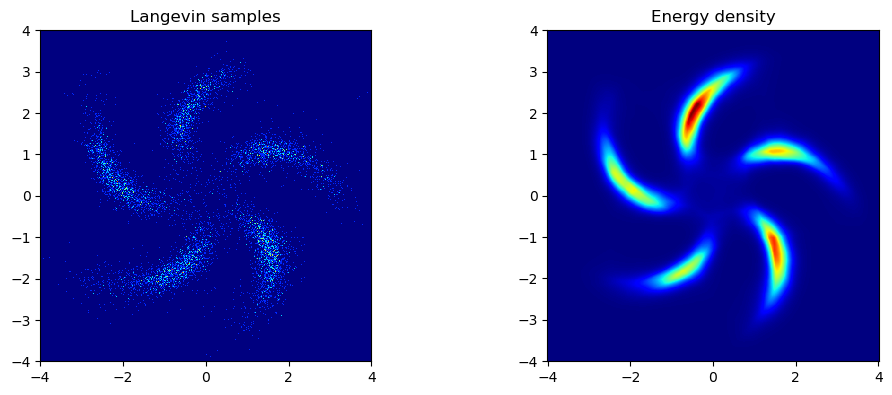

In [29]:
step_size = 0.01
n_initializations = 10
steps = 3000

ebm = torch.load('models/nce.pt').to(device)
fig, axs = plt.subplots(1, 2, figsize=(12,4.3), subplot_kw={'aspect': 'equal'})
samples = []
for j in range(n_initializations):
    x = 3*torch.randn(2).to(device)
    xs, _ = sample_langevin(x, ebm, step_size, steps, intermediate_samples=True, inverse=True)
    samples += [x_.detach().cpu().numpy() for x_ in xs]

samples = torch.tensor(np.array(samples))

n_pts = 700
range_lim = 4

xx, yy, zz = vis_nce.setup_grid(range_lim, n_pts, device)
log_prob = ebm.to('cpu')(zz.to('cpu')).detach()
prob = log_prob.exp().cpu()
# plot
vis_nce.plot_samples(samples, axs[0], range_lim, n_pts)
axs[0].set_title('Langevin samples')

axs[1].pcolormesh(xx, yy, prob.view(n_pts,n_pts), cmap=plt.cm.jet)
axs[1].set_facecolor(plt.cm.jet(0.))
axs[1].set_title('Energy density')